
notMNIST data set is a data set with 10 classes, (letters A-J taken from different fonts)

Implement a program (preferably using TensorFlow) that finds the best “W” which 
minimize binary cross-entropy
Apply stochastic mini-batch Gradient descent with weight-decay of 𝜆 = 0.01 for 
optimization and use 5000 iterations and mini-batch size of 500


In [1]:
import tensorflow as tf
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
from utils import *

In [2]:
# Load the notMNIST dataset
(trainData, trainTarget), (validData, validTarget), (testData, testTarget) = train_val_test_split()

In [3]:
class LogModel():
    def __init__(self, optimizer=None, learning_rate=0.01):
        super(LogModel, self).__init__()
        if optimizer:
            self.optimizer = optimizer(learning_rate)
        else:
            self.optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, decay=0.01)

    def loss(self, pred, true):
        loss = tf.keras.losses.BinaryCrossentropy()
        return loss(pred, true)

    def accuracy(self, pred, true):
        check_prediction = tf.equal(tf.round(pred), true)
        return tf.reduce_mean(tf.cast(check_prediction, tf.float32)) * 100

    def predict(self, x):
        return tf.nn.sigmoid(tf.matmul(x, self.w) + self.b)
        
    def fit(self, x, y, n_epochs, batch_size, validation_data=None):
        self.w = tf.Variable(tf.random.truncated_normal([x.shape[1], 1]), name="weight", trainable=True)
        self.b = tf.Variable(tf.zeros([1]), name='bias', trainable=True)     

        train_data=tf.data.Dataset.from_tensor_slices((x, y))
        train_data=train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)
        self.train_loss = []
        self.train_accuracy= []
        if validation_data:
            self.valid_accuracy = []
            self.valid_loss = []
        for step, (batch_x, batch_y) in enumerate(train_data.take(n_epochs), 1):
            # Run the optimization to update W and b values.
            with tf.GradientTape() as g:
                pred = tf.nn.sigmoid(tf.matmul(batch_x, self.w) + self.b)
                loss = self.loss(pred, batch_y)
                self.train_loss.append(loss)
                self.train_accuracy.append(self.accuracy(pred, batch_y))
            # Compute gradients.
            gradients = g.gradient(loss, [self.w, self.b])
            self.optimizer.apply_gradients(zip(gradients, [self.w, self.b]))
            if validation_data:
                x_val, y_val = validation_data
                pred_val = self.predict(x_val)
                self.valid_loss.append(self.loss(pred_val, y_val))
                self.valid_accuracy.append(self.accuracy(pred_val, y_val))
                
                if step % 50 == 0:
                    print("Iteration: %i, loss: %.2f, accuracy: %.2f, loss_val: %.2f, accuracy_val: %.2f" % (step, 
                    self.train_loss[step-1], self.train_accuracy[step-1], self.valid_loss[step-1], self.valid_accuracy[step-1]))
            else:
                if step % 50 == 0:
                    print("Iteration: %i, loss: %.2f, accuracy: %.2f" % (step, self.train_loss[step-1], self.train_accuracy[step-1]))

            


In [4]:
model = LogModel()
model.fit(trainData, trainTarget, 5000, 500, validation_data=(validData, validTarget))

Iteration: 50, loss: 7.28, accuracy: 52.60, loss_val: 7.49, accuracy_val: 50.80
Iteration: 100, loss: 5.67, accuracy: 62.80, loss_val: 5.57, accuracy_val: 63.10
Iteration: 150, loss: 3.39, accuracy: 79.00, loss_val: 3.29, accuracy_val: 80.21
Iteration: 200, loss: 1.81, accuracy: 88.80, loss_val: 2.37, accuracy_val: 85.03
Iteration: 250, loss: 1.58, accuracy: 90.80, loss_val: 1.97, accuracy_val: 87.17
Iteration: 300, loss: 1.65, accuracy: 89.60, loss_val: 1.75, accuracy_val: 87.70
Iteration: 350, loss: 1.72, accuracy: 88.60, loss_val: 1.60, accuracy_val: 90.37
Iteration: 400, loss: 1.17, accuracy: 93.40, loss_val: 1.48, accuracy_val: 90.91
Iteration: 450, loss: 1.17, accuracy: 93.00, loss_val: 1.39, accuracy_val: 91.44
Iteration: 500, loss: 1.14, accuracy: 93.00, loss_val: 1.33, accuracy_val: 91.98
Iteration: 550, loss: 1.15, accuracy: 92.60, loss_val: 1.29, accuracy_val: 91.98
Iteration: 600, loss: 1.11, accuracy: 93.60, loss_val: 1.25, accuracy_val: 92.51
Iteration: 650, loss: 1.24, a

In [5]:
print("Test accuracy: %.2f" % accuracy_score(testTarget, np.round(model.predict(testData))))
print("Confusion Matrix for test data")
print(confusion_matrix(testTarget, np.round(model.predict(testData))))

Test accuracy: 0.97
Confusion Matrix for test data
[[94  0]
 [ 5 89]]


True Label: C, predicted: J


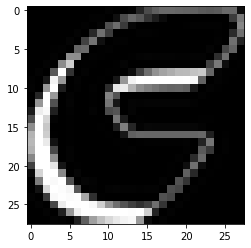

In [6]:
# Show a random false prediction each time this cell is run
false_test_preds = np.argwhere((testTarget !=np.round(model.predict(testData)))[:,0])
choice_idx = random.choice(false_test_preds)
print(f"True Label: {'C' if testTarget[choice_idx][0] else 'J'}, predicted: {'J' if testTarget[choice_idx][0] else 'C'}")
plt.imshow(testData[choice_idx].reshape((28, 28)), cmap='gray')
plt.show()

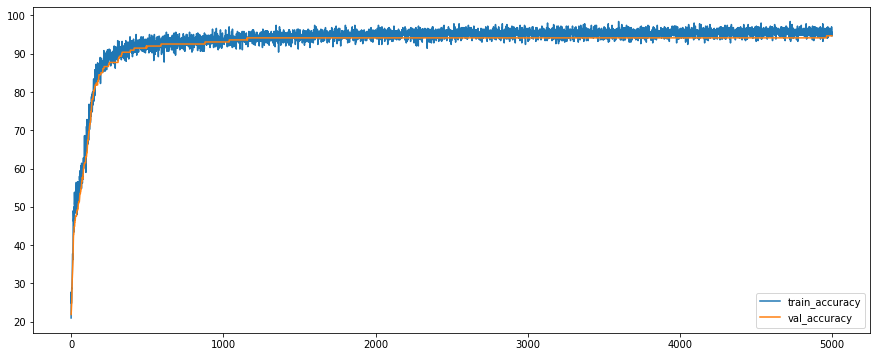

In [10]:
plt.figure(figsize=(15,6))
plt.plot(model.train_accuracy, label='train_accuracy')
plt.plot(model.valid_accuracy, label='val_accuracy')
plt.legend()
plt.show()

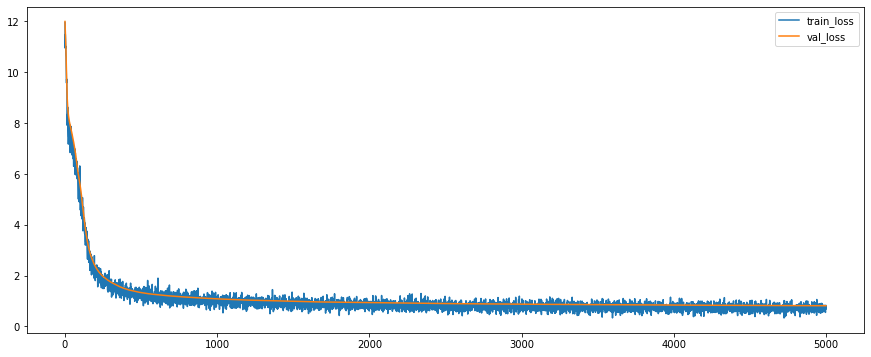

In [11]:
plt.figure(figsize=(15,6))
plt.plot(model.train_loss, label='train_loss')
plt.plot(model.valid_loss, label='val_loss')
plt.legend()
plt.show()